In [1]:
# Cell 1: Install all required packages
!pip install -q ultralytics ensemble-boxes kaggle
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q git+https://github.com/facebookresearch/detectron2.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.8 MB/s eta 0:00:00
  Pre

In [2]:
# Mount your Drive so we can read the .pt/.pth files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
from detectron2.model_zoo import get_config_file

# Base folder in YOUR Drive where the three weight-folders live
BASE = "/content/drive/MyDrive/group-project"

# Verify these match your screenshots!
RTDETR_WEIGHTS    = os.path.join(BASE, "RTDETR",           "RT-DETR best.pt")
RETINANET_WEIGHTS = os.path.join(BASE, "RetinanetR50",     "Retinanet best.pth")
FRCNN_WEIGHTS     = os.path.join(BASE, "Faster RCNN-R101fpn", "RCNN best.pth")

# Load Detectron2 zoo configs directly
RETINANET_CFG = get_config_file("COCO-Detection/retinanet_R_50_FPN_1x.yaml")
FRCNN_CFG     = get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")

# Local folders for your inference
INPUT_DIR  = "images/input"   # where you'll place or copy your test .jpgs
OUTPUT_DIR = "images/output"  # where results will be written

print("RTDETR weights at:", RTDETR_WEIGHTS)
print("RetinaNet weights at:", RETINANET_WEIGHTS)
print("Faster R-CNN weights at:", FRCNN_WEIGHTS)
print("Configs:", RETINANET_CFG, FRCNN_CFG)


RTDETR weights at: /content/drive/MyDrive/group-project/RTDETR/RT-DETR best.pt
RetinaNet weights at: /content/drive/MyDrive/group-project/RetinanetR50/Retinanet best.pth
Faster R-CNN weights at: /content/drive/MyDrive/group-project/Faster RCNN-R101fpn/RCNN best.pth
Configs: /usr/local/lib/python3.11/dist-packages/detectron2/model_zoo/configs/COCO-Detection/retinanet_R_50_FPN_1x.yaml /usr/local/lib/python3.11/dist-packages/detectron2/model_zoo/configs/COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml


In [5]:
# Cell 4: Copy 5 random .jpgs from your val set into INPUT_DIR

import os, random, shutil

# Update this to the location of your val images in Drive
SRC = "/content/drive/MyDrive/group-project/val"

os.makedirs(INPUT_DIR, exist_ok=True)
all_jpg = [f for f in os.listdir(SRC) if f.lower().endswith(".jpg")]

# Randomly pick 5 and copy them
for img in random.sample(all_jpg, 5):
    shutil.copy(os.path.join(SRC, img), os.path.join(INPUT_DIR, img))

print("Images now in", INPUT_DIR, ":", os.listdir(INPUT_DIR))


Images now in images/input : ['Copy of 2011_002108.jpg', 'Copy of 2011_000066.jpg', 'Copy of 2011_003149.jpg', 'Copy of 2010_003467.jpg', 'Copy of 2011_001568.jpg']


In [ ]:
# Cell 5: Load the three models, run RT-DETR + RetinaNet + Faster R-CNN, ensemble via WBF, and save

import os, logging
from glob import glob

import cv2
import torch
import numpy as np
from ultralytics import RTDETR
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from ensemble_boxes import weighted_boxes_fusion

# ─── Helper functions ─────────────────────────────────────────────────────────

def load_rtdetr_model(weight_path, conf_thresh):
    model = RTDETR(weight_path)
    model.model.conf = conf_thresh
    return model

def load_detectron2_model(cfg_file, weight_path, device, score_thresh):
    cfg = get_cfg()
    cfg.merge_from_file(cfg_file)
    cfg.MODEL.WEIGHTS = weight_path
    cfg.MODEL.DEVICE = device
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = score_thresh
    return DefaultPredictor(cfg)

def preds_rtdetr(model, img):
    res = model(img)[0].boxes
    return res.xyxy.cpu().numpy(), res.conf.cpu().numpy(), res.cls.cpu().numpy().astype(int)

def preds_detectron2(predictor, img):
    inst = predictor(img)["instances"].to("cpu")
    return inst.pred_boxes.tensor.numpy(), inst.scores.numpy(), inst.pred_classes.numpy()

def fuse_wbf(all_boxes, all_scores, all_labels, image_shape, iou_thr, skip_thr):
    h, w = image_shape
    boxes_norm = [b / [w, h, w, h] for b in all_boxes]
    boxes, scores, labels = weighted_boxes_fusion(
        boxes_norm, all_scores, all_labels,
        iou_thr=iou_thr, skip_box_thr=skip_thr
    )
    return boxes * [w, h, w, h], scores, labels

def annotate_and_save(img, boxes, scores, labels, class_names, out_path):
    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(
            img,
            f"{class_names[label]}: {score:.2f}",
            (x1, y1 - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 255, 0),
            1
        )
    cv2.imwrite(out_path, img)

# ─── Main execution ───────────────────────────────────────────────────────────

logging.basicConfig(level=logging.INFO)
os.makedirs(OUTPUT_DIR, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load each model
rtdetr_model    = load_rtdetr_model(RTDETR_WEIGHTS,    conf_thresh=0.25)
retinanet_model = load_detectron2_model(RETINANET_CFG, RETINANET_WEIGHTS, device, score_thresh=0.25)
frcnn_model     = load_detectron2_model(FRCNN_CFG,      FRCNN_WEIGHTS,     device, score_thresh=0.25)

# VOC 2012 class names
VOC_CLASSES = {
    0:'aeroplane',1:'bicycle',2:'bird',3:'boat',4:'bottle',
    5:'bus',6:'car',7:'cat',8:'chair',9:'cow',
   10:'diningtable',11:'dog',12:'horse',13:'motorbike',14:'person',
   15:'pottedplant',16:'sheep',17:'sofa',18:'train',19:'tvmonitor'
}

# Iterate over your 5 test images
for img_path in sorted(glob(os.path.join(INPUT_DIR, "*.jpg"))):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    logging.info(f"Processing {img_path}")

    # Get per-model predictions
    b1, s1, l1 = preds_rtdetr(rtdetr_model, img)
    b2, s2, l2 = preds_detectron2(retinanet_model, img)
    b3, s3, l3 = preds_detectron2(frcnn_model, img)

    # Fuse with WBF
    boxes, scores, labels = fuse_wbf(
        [b1, b2, b3], [s1, s2, s3], [l1, l2, l3],
        image_shape=(h, w), iou_thr=0.5, skip_thr=0.001
    )

    # Annotate and save
    out_file = os.path.join(OUTPUT_DIR, os.path.basename(img_path))
    annotate_and_save(img.copy(), boxes, scores, labels, VOC_CLASSES, out_file)

logging.info(f"Ensembling completed. Check {OUTPUT_DIR}")


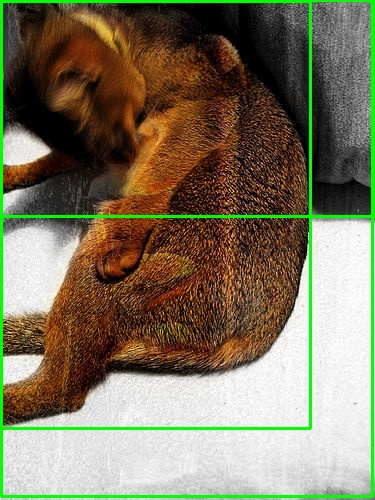

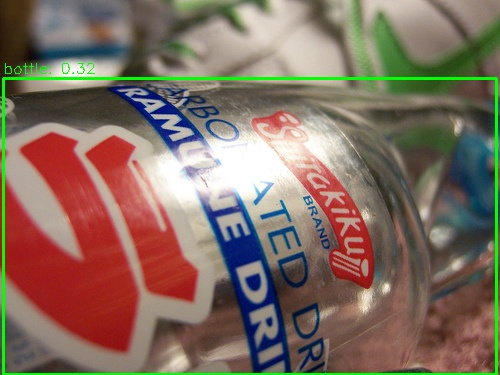

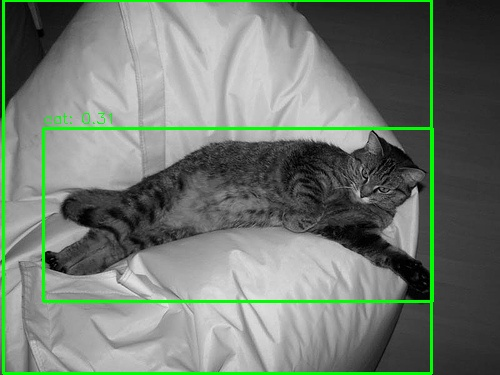

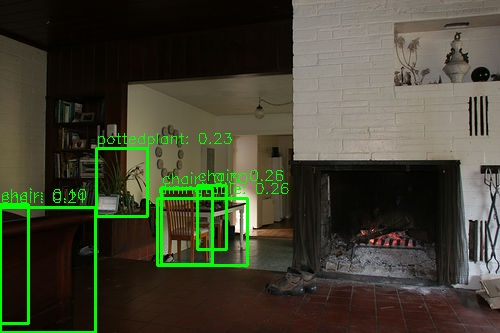

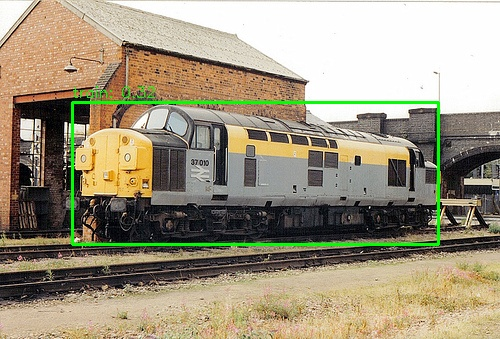

In [7]:
# Cell 6: Show all ensembled output images inline
import os
from IPython.display import Image, display

for fname in sorted(os.listdir(OUTPUT_DIR)):
    display(Image(filename=os.path.join(OUTPUT_DIR, fname)))
